In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, kstest, kurtosis
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor

import lightgbm as lgb


In [3]:
train_df=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')


In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
test_df=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')


# Doing scatterplot for numerical columns To Remove outliers


In [8]:
# At first we will do scatterplot for numeric columns and remove outliers
def plot_data_scatterplot_for_train_df(x):
    
   plt.figure(figsize=(5, 3))
   sns.scatterplot(x=x, y='YrSold', data=train_df)
   plt.show()

In [9]:
train_df.columns[train_df.dtypes != 'object']


Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

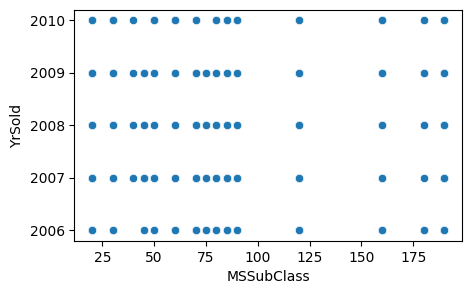

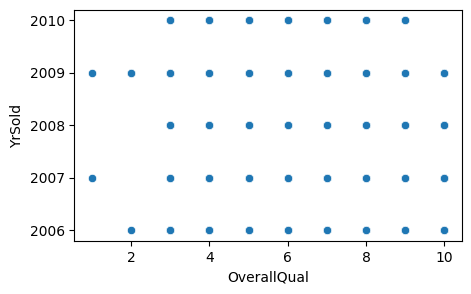

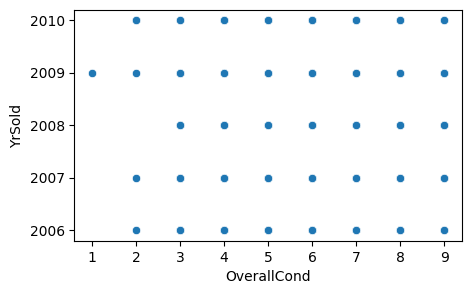

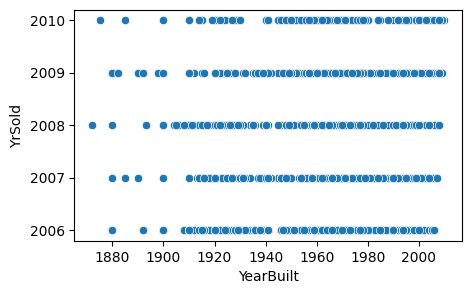

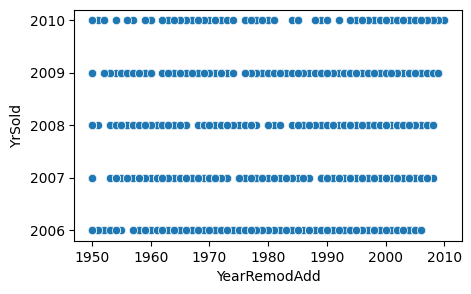

In [10]:
plot_data_scatterplot_for_train_df('MSSubClass')
plot_data_scatterplot_for_train_df('OverallQual')
plot_data_scatterplot_for_train_df('OverallCond')
plot_data_scatterplot_for_train_df('YearBuilt')
plot_data_scatterplot_for_train_df('YearRemodAdd')

* in the above columns don't have outliers



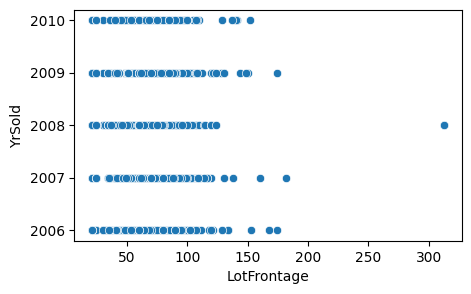

In [11]:
plot_data_scatterplot_for_train_df('LotFrontage')


In [12]:
train_df.query('LotFrontage> 250')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


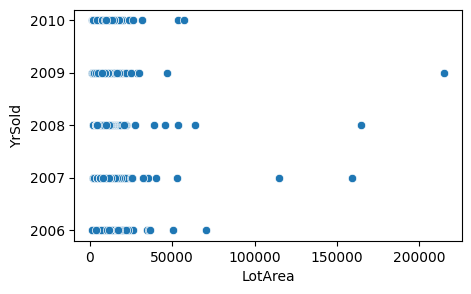

In [13]:
plot_data_scatterplot_for_train_df('LotArea')


In [14]:
train_df.query('LotArea >100000')


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000


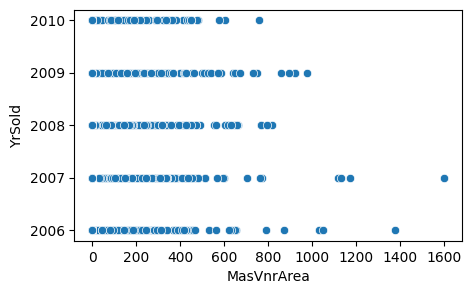

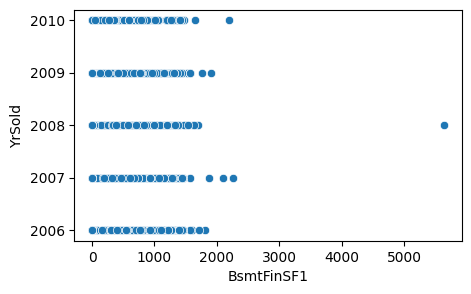

In [15]:
plot_data_scatterplot_for_train_df('MasVnrArea')
plot_data_scatterplot_for_train_df('BsmtFinSF1')

In [16]:
train_df.query('BsmtFinSF1 >4000')


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [17]:
train_df.query('MasVnrArea >1200')


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
297,298,60,FV,66.0,7399,Pave,Pave,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,239000
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000


In [18]:
values = [934,1298,298,1170,250,314,336,707,1299,323,305,692,206,1424,198,347,1231,1329,584,496,54,333,441,497,1183,692,524]
train_df = train_df[train_df.Id.isin(values) == False]

In [19]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [20]:
train_df[['GarageCond', 'GarageYrBlt', 'GarageType', 'GarageFinish', 
    'GarageQual']]

,GarageCond,GarageYrBlt,GarageType,GarageFinish,GarageQual
0,TA,2003.0,Attchd,RFn,TA
1,TA,1976.0,Attchd,RFn,TA
2,TA,2001.0,Attchd,RFn,TA
3,TA,1998.0,Detchd,Unf,TA
4,TA,2000.0,Attchd,RFn,TA
...,...,...,...,...,...
1455,TA,1999.0,Attchd,RFn,TA
1456,TA,1978.0,Attchd,Unf,TA
1457,TA,1941.0,Attchd,RFn,TA
1458,TA,1950.0,Attchd,Unf,TA


# Handling Null Values In Data Set


In [21]:
pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20)


,0
PoolQC,1431
MiscFeature,1385
Alley,1345
Fence,1159
MasVnrType,858
FireplaceQu,685
LotFrontage,252
GarageYrBlt,80
GarageCond,80
GarageType,80


In [22]:
# Filling columns with 'No' for categorical columns
columns_fill_no = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 
    'FireplaceQu', 'GarageCond', 'GarageYrBlt', 'GarageType', 'GarageFinish', 
    'GarageQual', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 
    'BsmtCond', 'BsmtFinType1', 'Electrical'
]
for col in columns_fill_no:
    train_df[col] = train_df[col].fillna('No')
    test_df[col] = test_df[col].fillna('No')

# Filling columns with 0 for numerical columns
columns_fill_zero = ['MasVnrArea', 'LotFrontage']
for col in columns_fill_zero:
    train_df[col] = train_df[col].fillna(0)
    test_df[col] = test_df[col].fillna(0)


In [23]:
train_df['SalePrice']

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1434, dtype: int64

In [24]:
pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20)


,0
Id,0
CentralAir,0
GarageYrBlt,0
GarageType,0
FireplaceQu,0
Fireplaces,0
Functional,0
TotRmsAbvGrd,0
KitchenQual,0
KitchenAbvGr,0


# Feature Engineering


<Axes: >

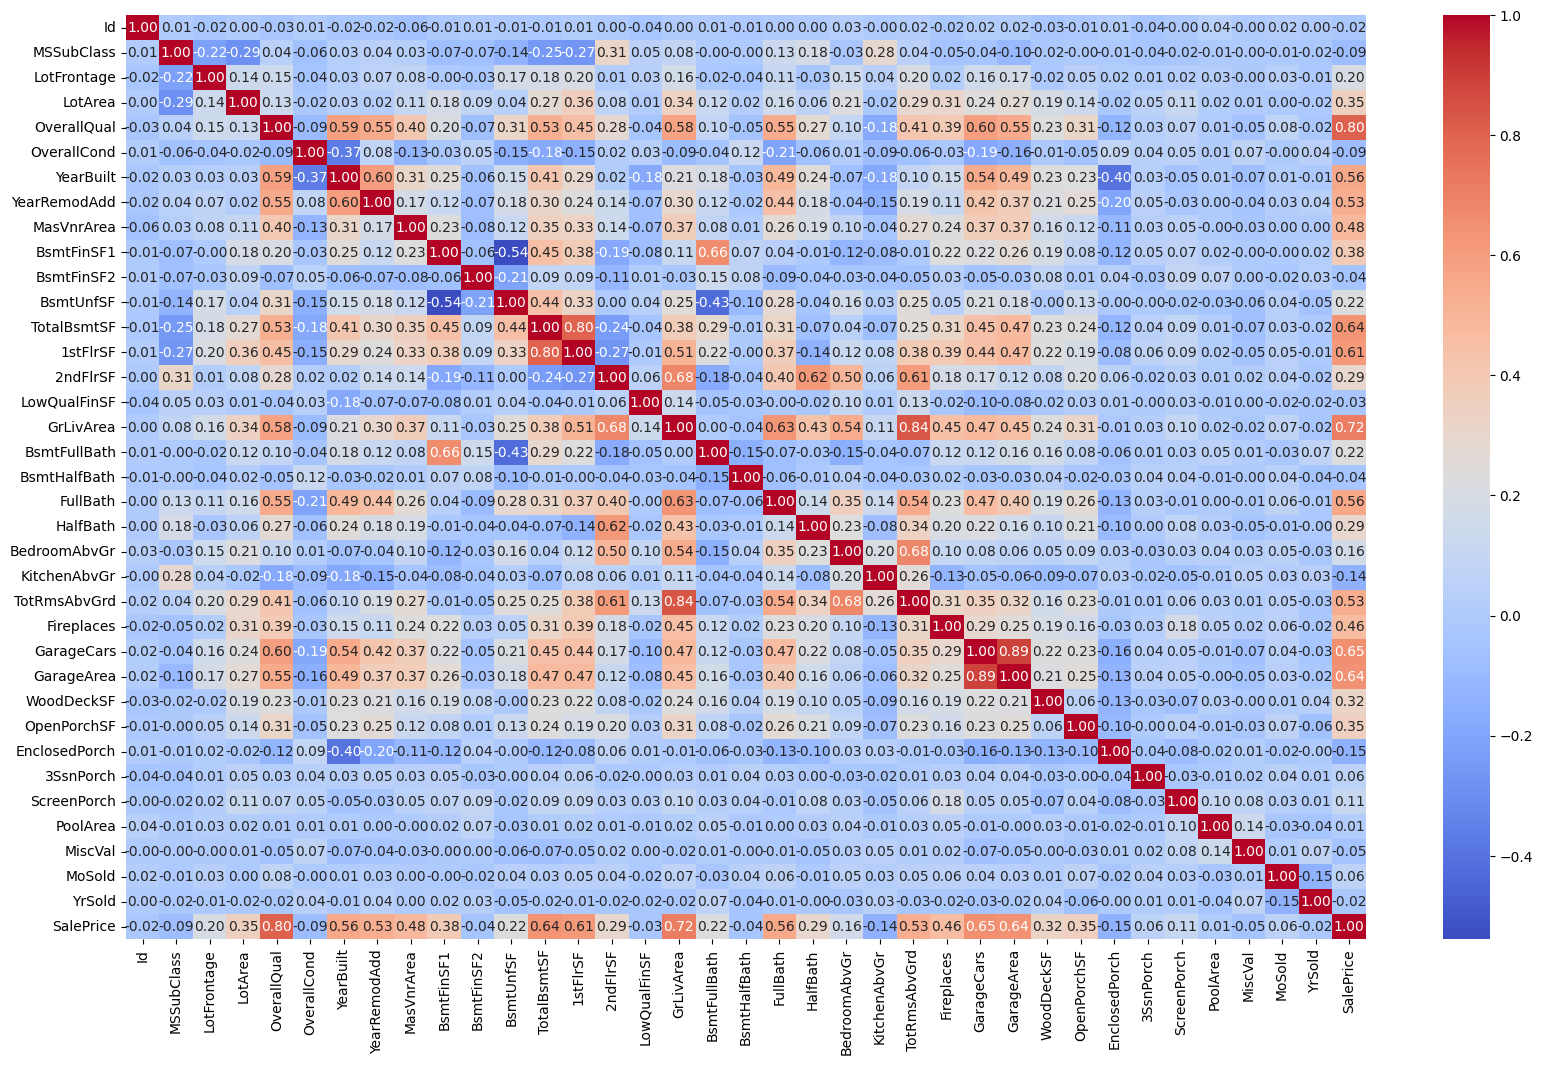

In [25]:
correlation_matrix = train_df.corr(numeric_only=True)
#correlation_matrix

plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [26]:
print(type(train_df))


<class 'pandas.core.frame.DataFrame'>


In [27]:
train_df['totalbaths'] = train_df['BsmtFullBath'] + train_df['FullBath'] + 0.5 * (train_df['BsmtHalfBath'] + train_df['HalfBath']) 
test_df['totalbaths'] = test_df['BsmtFullBath'] + test_df['FullBath'] + 0.5 * (test_df['BsmtHalfBath'] + test_df['HalfBath']) 
train_df['totalporchsf'] = train_df['OpenPorchSF'] + train_df['3SsnPorch'] + train_df['EnclosedPorch'] + train_df['ScreenPorch'] + train_df['WoodDeckSF']
test_df['totalporchsf'] = test_df['OpenPorchSF'] + test_df['3SsnPorch'] + test_df['EnclosedPorch'] + test_df['ScreenPorch'] + test_df['WoodDeckSF']
train_df['TotalRooms'] = train_df['TotRmsAbvGrd'] + train_df['FullBath'] + train_df['HalfBath']
test_df['TotalRooms'] = train_df['TotRmsAbvGrd'] + train_df['FullBath'] + train_df['HalfBath']

In [28]:
train_df['houseage'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['houseage'] = test_df['YrSold'] - test_df['YearBuilt']
train_df['houseremodelage'] = train_df['YrSold'] - train_df['YearRemodAdd']
test_df['houseremodelage'] = test_df['YrSold'] - test_df['YearRemodAdd']
train_df['totalsf'] = train_df['1stFlrSF'] + train_df['2ndFlrSF'] + train_df['BsmtFinSF1'] + train_df['BsmtFinSF2']
test_df['totalsf'] = test_df['1stFlrSF'] + test_df['2ndFlrSF'] + test_df['BsmtFinSF1'] + test_df['BsmtFinSF2']
train_df['totalarea'] = train_df['GrLivArea'] + train_df['TotalBsmtSF']
test_df['totalarea'] = test_df['GrLivArea'] + test_df['TotalBsmtSF']

In [29]:
train_df['SalePrice']

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1434, dtype: int64

In [30]:
train_df['GarageYrBlt']

0       2003.0
1       1976.0
2       2001.0
3       1998.0
4       2000.0
         ...  
1455    1999.0
1456    1978.0
1457    1941.0
1458    1950.0
1459    1965.0
Name: GarageYrBlt, Length: 1434, dtype: object

In [31]:
test_df['GarageYrBlt']

0       1961.0
1       1958.0
2       1997.0
3       1998.0
4       1992.0
         ...  
1454        No
1455    1970.0
1456    1960.0
1457        No
1458    1993.0
Name: GarageYrBlt, Length: 1459, dtype: object

In [32]:
# Convert 'GarageYrBlt' to numeric, coercing errors (invalid data becomes NaN)
train_df['GarageYrBlt'] = pd.to_numeric(train_df['GarageYrBlt'], errors='coerce')
test_df['GarageYrBlt'] = pd.to_numeric(test_df['GarageYrBlt'], errors='coerce')

# Now calculate 'garageage' (2024 - the year the garage was built)
train_df['garageage'] = 2024 - train_df['GarageYrBlt'].fillna(0)
test_df['garageage'] = 2024 - test_df['GarageYrBlt'].fillna(0)

# Verify the changes
print(train_df[['GarageYrBlt', 'garageage']].head())
print(test_df[['GarageYrBlt', 'garageage']].head())


   GarageYrBlt  garageage
0       2003.0       21.0
1       1976.0       48.0
2       2001.0       23.0
3       1998.0       26.0
4       2000.0       24.0
   GarageYrBlt  garageage
0       1961.0       63.0
1       1958.0       66.0
2       1997.0       27.0
3       1998.0       26.0
4       1992.0       32.0


In [33]:
train_df['garageage']
test_df['garageage']

0         63.0
1         66.0
2         27.0
3         26.0
4         32.0
         ...  
1454    2024.0
1455      54.0
1456      64.0
1457    2024.0
1458      31.0
Name: garageage, Length: 1459, dtype: float64

In [34]:
train_df = train_df.drop(columns=[ 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])
test_df = test_df.drop(columns=[ 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])

In [35]:
train_df = train_df.drop(columns=['Id','YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath','BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])
test_df = test_df.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath','HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])

In [36]:
train_df.shape

(1434, 67)

In [37]:
train_df = train_df.drop(columns=['GarageArea'])
test_df = test_df.drop(columns=['GarageArea'])

# We will log transform the 'SalePrice' column


In [38]:
#print(train_df['SalePrice'].max())
#print(train_df.info())
#print(train_df.describe())

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


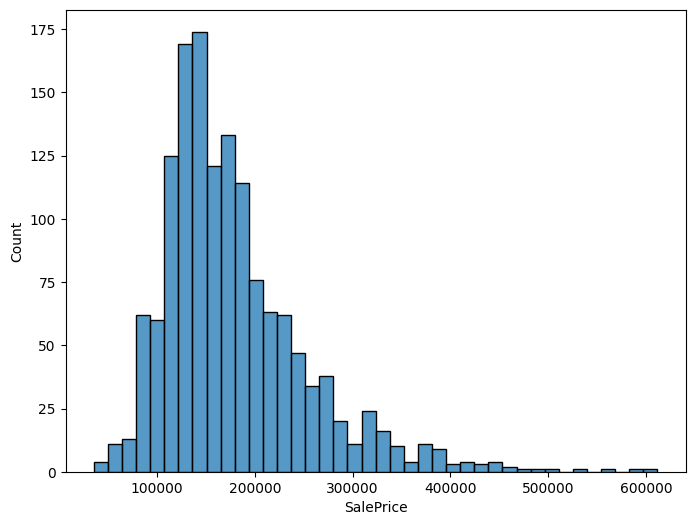

In [39]:
plt.figure(figsize = (8,6))
sns.histplot(x = train_df['SalePrice'])
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness of SalePrice: 1.4966712633557329


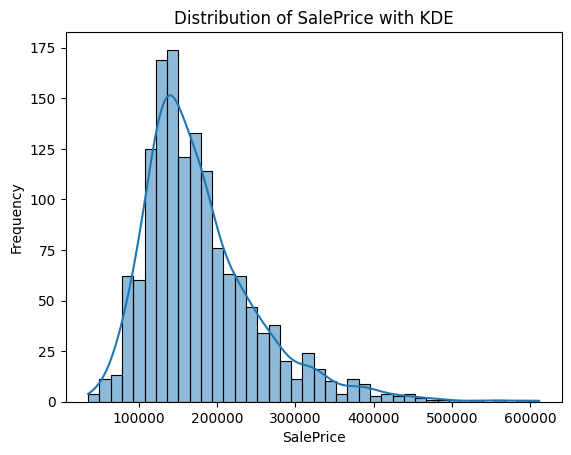

In [40]:
sns.histplot(train_df['SalePrice'], kde=True)
skewness = train_df['SalePrice'].skew()
print("Skewness of SalePrice:", skewness)
plt.title('Distribution of SalePrice with KDE')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

In [41]:
# Check skewness and kurtosis
skewness = train_df['SalePrice'].skew()
kurtosis = train_df['SalePrice'].kurtosis()
print(f'Skewness: {skewness},\nKurtosis: {kurtosis}\n')
# Shapiro-Wilk test
shapiro_stat, shapiro_p = shapiro(train_df['SalePrice'])
print(f'Shapiro-Wilk test statistic: {shapiro_stat},\np-value: {shapiro_p}\n')

# Kolmogorov-Smirnov test
ks_stat, ks_p = kstest(train_df['SalePrice'], 'norm')
print(f'K-S test statistic: {ks_stat}, \np-value: {ks_p}')

Skewness: 1.4966712633557329,
Kurtosis: 3.4540817201083183

Shapiro-Wilk test statistic: 0.897946204260423,
p-value: 7.585873273617024e-30

K-S test statistic: 1.0, 
p-value: 0.0


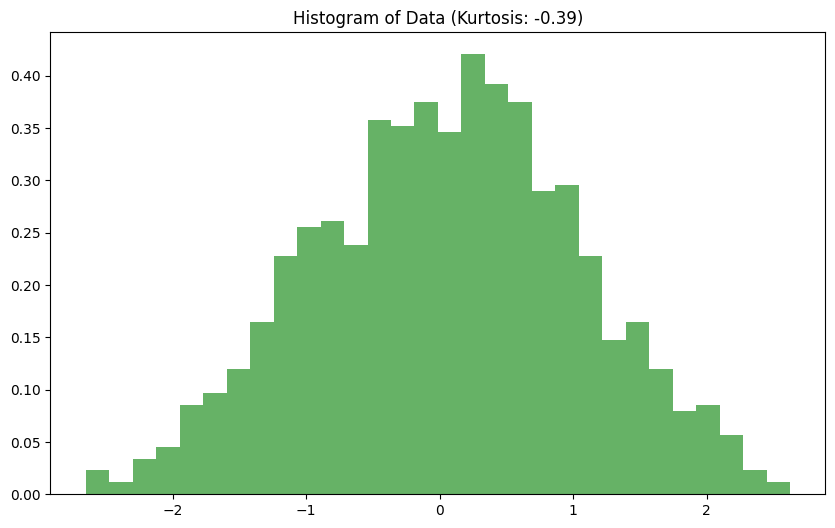

In [42]:
import numpy as np
from scipy.stats import kurtosis
import matplotlib.pyplot as plt

# Generate random data
data = np.random.normal(loc=0, scale=1, size=1000)

# Calculate kurtosis
kurt_value = kurtosis(data)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
plt.title(f'Histogram of Data (Kurtosis: {kurt_value:.2f})')
plt.show()


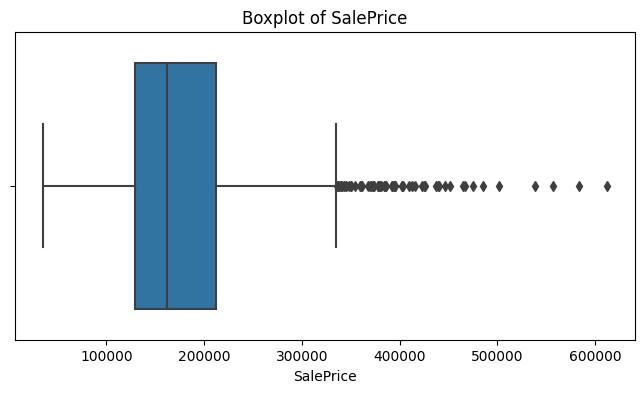

In [43]:
# Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=train_df['SalePrice'])
plt.title('Boxplot of SalePrice')
plt.show()

In [44]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])


In [45]:
train_df['SalePrice']

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1434, dtype: float64

In [46]:
# Check skewness and kurtosis
skewness = train_df['SalePrice'].skew()
kurtosis = train_df['SalePrice'].kurtosis()
print(f'Skewness: {skewness},\nKurtosis: {kurtosis}\n')
# Shapiro-Wilk test
shapiro_stat, shapiro_p = shapiro(train_df['SalePrice'])
print(f'Shapiro-Wilk test statistic: {shapiro_stat},\np-value: {shapiro_p}\n')

# Kolmogorov-Smirnov test
ks_stat, ks_p = kstest(train_df['SalePrice'], 'norm')
print(f'K-S test statistic: {ks_stat}, \np-value: {ks_p}')

Skewness: 0.07425367411330136,
Kurtosis: 0.5672269285623845

Shapiro-Wilk test statistic: 0.9933153312336251,
p-value: 4.498489357284492e-06

K-S test statistic: 1.0, 
p-value: 0.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness of SalePrice: 0.07425367411330136


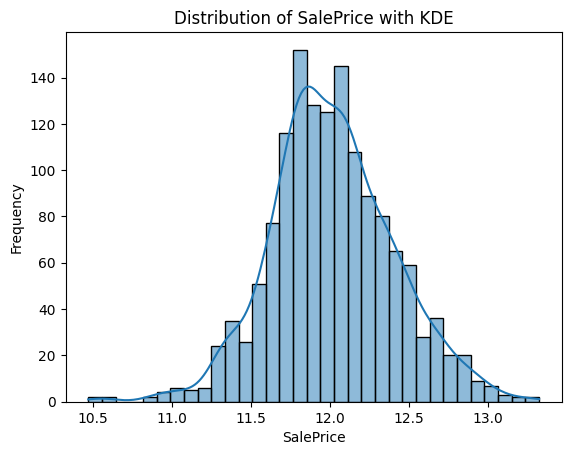

In [47]:
sns.histplot(train_df['SalePrice'], kde=True)
skewness = train_df['SalePrice'].skew()
print("Skewness of SalePrice:", skewness)
plt.title('Distribution of SalePrice with KDE')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

# Encoding of columns


In [48]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SaleCondition,SalePrice,totalbaths,totalporchsf,TotalRooms,houseage,houseremodelage,totalsf,totalarea,garageage
0,60,RL,65.0,8450,Pave,No,Reg,Lvl,AllPub,Inside,...,Normal,12.247699,3.5,61,11,5,5,2416,2566,21.0
1,20,RL,80.0,9600,Pave,No,Reg,Lvl,AllPub,FR2,...,Normal,12.109016,2.5,298,8,31,31,2240,2524,48.0
2,60,RL,68.0,11250,Pave,No,IR1,Lvl,AllPub,Inside,...,Normal,12.317171,3.5,42,9,7,6,2272,2706,23.0
3,70,RL,60.0,9550,Pave,No,IR1,Lvl,AllPub,Corner,...,Abnorml,11.849405,2.0,307,8,91,36,1933,2473,26.0
4,60,RL,84.0,14260,Pave,No,IR1,Lvl,AllPub,FR2,...,Normal,12.429220,3.5,276,12,8,8,2853,3343,24.0


In [49]:
# Group by dtypes and print unique counts for each group
for dtype, group in train_df.groupby(train_df.dtypes, axis=1):
    print(f"Data type: {dtype}")
    print(group.nunique())
    print("\n")


Data type: int64
MSSubClass           15
LotArea            1050
OverallQual          10
OverallCond           9
BsmtUnfSF           772
LowQualFinSF         23
BedroomAbvGr          8
KitchenAbvGr          4
TotRmsAbvGrd         12
Fireplaces            4
GarageCars            5
PoolArea              4
MiscVal              18
MoSold               12
totalporchsf        416
TotalRooms           14
houseage            120
houseremodelage      61
totalsf            1031
totalarea           940
dtype: int64


Data type: float64
LotFrontage    109
MasVnrArea     321
SalePrice      650
totalbaths      10
garageage       98
dtype: int64


Data type: object
MSZoning          5
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        6
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          7
Exterior1st      15
Exterior2nd      16
M

/tmp/ipykernel_17/2471087789.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for dtype, group in train_df.groupby(train_df.dtypes, axis=1):


In [50]:
ode_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  'Functional', 'PoolQC','Fence',
           'FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond']

ohe_cols = ['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 
           'MasVnrType','Foundation',  'Electrical',  'SaleType', 'MSZoning', 'SaleCondition', 'Heating', 'GarageType', 'RoofMatl','MiscFeature','Alley']

In [51]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')
num_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtUnfSF', 'LowQualFinSF', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea',
       'MiscVal', 'MoSold', 'totalbaths', 'totalporchsf', 'TotalRooms',
       'houseage', 'houseremodelage', 'totalsf', 'totalarea', 'garageage'],
      dtype='object')

In [52]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1434 entries, 0 to 1459
Data columns (total 66 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSSubClass       1434 non-null   int64  
 1   MSZoning         1434 non-null   object 
 2   LotFrontage      1434 non-null   float64
 3   LotArea          1434 non-null   int64  
 4   Street           1434 non-null   object 
 5   Alley            1434 non-null   object 
 6   LotShape         1434 non-null   object 
 7   LandContour      1434 non-null   object 
 8   Utilities        1434 non-null   object 
 9   LotConfig        1434 non-null   object 
 10  LandSlope        1434 non-null   object 
 11  Neighborhood     1434 non-null   object 
 12  Condition1       1434 non-null   object 
 13  Condition2       1434 non-null   object 
 14  BldgType         1434 non-null   object 
 15  HouseStyle       1434 non-null   object 
 16  OverallQual      1434 non-null   int64  
 17  OverallCond      14

# Creating Pipelines


In [53]:
train_df['SalePrice']

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1434, dtype: float64

In [54]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


* Building Column transformer

In [55]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

# Splitting data


In [56]:
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

In [57]:
X_preprocessed = col_trans.fit_transform(X)


In [58]:
X_preprocessed

array([[ 0.07366402,  0.23113654, -0.28517324, ...,  0.        ,
         1.        ,  0.        ],
       [-0.87266705,  0.67831651, -0.06628592, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.07366402,  0.32057253,  0.2477698 , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.31024679,  0.26094854, -0.17249385, ...,  0.        ,
         1.        ,  0.        ],
       [-0.87266705,  0.32057253, -0.04401651, ...,  0.        ,
         1.        ,  0.        ],
       [-0.87266705,  0.52925652, -0.00214242, ...,  0.        ,
         1.        ,  0.        ]])

In [59]:
y

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1434, dtype: float64

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=25)

# Model Training


In [61]:
RFR = RandomForestRegressor(random_state=13)
param_grid_RFR = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 250, 500],
    'min_samples_split': [3, 5, 10]
}
rfr_cv = GridSearchCV(RFR, param_grid_RFR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rfr_cv.fit(X_train, y_train)
rfr_cv.best_params_


{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 250}

In [62]:
np.sqrt(-1 * rfr_cv.best_score_)


0.12958638050272378

In [63]:
rfr_final = RandomForestRegressor(max_depth= 15, min_samples_split=3, n_estimators= 500,random_state=13)
rfr_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_split=3, n_estimators=500,
                      random_state=13)

In [64]:
XGB = XGBRegressor(random_state=13)
param_grid_XGB = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],}
xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_cv.fit(X_train, y_train)
xgb_cv.best_params_

{'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 300,
 'subsample': 0.8}

In [65]:
np.sqrt(-1 * xgb_cv.best_score_)


0.11194611516187312

In [66]:
xgb_final = XGBRegressor(random_state=13,colsample_bytree= 0.8,gamma= 0,learning_rate= 0.05,max_depth= 3,min_child_weight= 3,n_estimators=300,subsample= 0.8)
xgb_final.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=13, ...)

In [67]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the Ridge regression model
ridge = Ridge()

# Define the parameter grid
param_grid_ridge = {
    'alpha': [0.05, 0.1, 1, 3, 5, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag'], 
    'max_iter': [1000, 5000, 10000]
}

# Initialize GridSearchCV
ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')

# Fit the model
try:
    ridge_cv.fit(X_train, y_train)
    best_rmse = np.sqrt(-1 * ridge_cv.best_score_)
    best_params = ridge_cv.best_params_
    
    print(f"Best RMSE: {best_rmse:.4f}")
    print(f"Best Parameters: {best_params}")
except Exception as e:
    print(f"An error occurred during grid search: {e}")


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best RMSE: 0.1112
Best Parameters: {'alpha': 10, 'max_iter': 5000, 'solver': 'sag'}


In [68]:
np.sqrt(-1 * ridge_cv.best_score_)


0.11119710227976783

In [69]:
ridge_final=Ridge(alpha=10, solver= 'sag')
ridge_final.fit(X_train, y_train)

Ridge(alpha=10, solver='sag')

In [70]:
lgbm_regressor = lgb.LGBMRegressor()
param_grid_lgbm = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'verbosity': [-1]
}
lgbm_cv = GridSearchCV(lgbm_regressor, param_grid_lgbm, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
lgbm_cv.fit(X_train, y_train)
lgbm_cv.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'n_estimators': 100,
 'num_leaves': 20,
 'verbosity': -1}

In [71]:
np.sqrt(-1 * lgbm_cv.best_score_)


0.12151720732996979

In [72]:
lgbm_final = lgb.LGBMRegressor(boosting_type= 'gbdt',learning_rate= 0.05,n_estimators= 200,num_leaves=20)
lgbm_final.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2125
[LightGBM] [Info] Number of data points in the train set: 1147, number of used features: 122
[LightGBM] [Info] Start training from score 12.020165


LGBMRegressor(learning_rate=0.05, n_estimators=200, num_leaves=20)

In [73]:
catboost = CatBoostRegressor(loss_function='RMSE', verbose=False)
param_grid_cat ={
    'iterations': [100, 500, 1000],
    'depth': [5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}
cat_cv = GridSearchCV(catboost, param_grid_cat, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
cat_cv.fit(X_train, y_train)
cat_cv.best_params_

{'depth': 5, 'iterations': 500, 'learning_rate': 0.05}

In [74]:
np.sqrt(-1 * cat_cv.best_score_)


0.11549505831953957

In [75]:
catboost_final=CatBoostRegressor(loss_function='RMSE', verbose=False,depth=5,iterations= 500, learning_rate= 0.05)
catboost_final.fit(X_train, y_train)

# Voting and Stacking


In [76]:
vr = VotingRegressor([('rfr', rfr_final),
                      ('xgb', xgb_final),
                      ('ridge', ridge_final),
                      ('lgbm',lgbm_final),
                      ('cat',catboost_final)],
                    weights=[1,1,1,1,1])
vr.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2125
[LightGBM] [Info] Number of data points in the train set: 1147, number of used features: 122
[LightGBM] [Info] Start training from score 12.020165


VotingRegressor(estimators=[('rfr',
                             RandomForestRegressor(max_depth=15,
                                                   min_samples_split=3,
                                                   n_estimators=500,
                                                   random_state=13)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=...
                                          max_leaves=None, min_child_weight=3,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=300,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=13, ...)),
                            ('ridge', Ridge(alpha=10, solver='sag')),
                            ('lgbm',
                             LGBMRegressor(learning_rate=0.05, n_estimators=200,
                                           num_leaves=20)),
                            ('cat',
                             <catboost.core.CatBoostRegressor object at 0x7c5aa5615780>)],
                weights=[1, 1, 1, 1, 1])

In [77]:
y_pred_vr = vr.predict(X_test)
mean_squared_error(y_test, y_pred_vr, squared=False)

0.13025428845608153

In [78]:
estimators = [
    
    ('xgb', xgb_final),
    ('cat', catboost_final),
    ('lgb', lgbm_final),
    ('rfr', rfr_final),
    ('ridge', ridge_final)

]
stackreg = StackingRegressor(
            estimators = estimators,
    final_estimator= vr
   
)
stackreg.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2125
[LightGBM] [Info] Number of data points in the train set: 1147, number of used features: 122
[LightGBM] [Info] Start training from score 12.020165
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2004
[LightGBM] [Info] Number of data points in the train set: 917, number of used features: 116
[LightGBM] [Info] Start training from score 12.025895
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0...
                                                                            min_child_weight=3,
                                                                            missing=nan,
                                                                            monotone_constraints=None,
                                                                            multi_strategy=None,
                                                                            n_estimators=300,
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None,
                                                                            random_state=13, ...)),
                                                              ('ridge',
                                                               Ridge(alpha=10,
                                                                     solver='sag')),
                                                              ('lgbm',
                                                               LGBMRegressor(learning_rate=0.05,
                                                                             n_estimators=200,
                                                                             num_leaves=20)),
                                                              ('cat',
                                                               <catboost.core.CatBoostRegressor object at 0x7c5aa5615780>)],
                                                  weights=[1, 1, 1, 1, 1]))

In [79]:
y_pred_stack = stackreg.predict(X_test)
mean_squared_error(y_test, y_pred_stack, squared=False)

0.12956639457468902

# Creating submission.csv


In [80]:
if 'garageage' in test_df.columns:
    print("yes")

yes


In [81]:
df_test_preprocess = col_trans.transform(test_df)
y_stacking = np.exp(stackreg.predict(df_test_preprocess))

df_y_stacking_out = test_df[['Id']]
df_y_stacking_out['SalePrice'] = y_stacking

df_y_stacking_out.to_csv('submission.csv', index=False)

/tmp/ipykernel_17/3958496174.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_stacking_out['SalePrice'] = y_stacking
